In [1]:
%load_ext autoreload

In [384]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE
from scipy.fftpack import fft, ifft, ifftshift
from scipy.signal import butter, lfilter
from spynal.spikes import density
import sys
import torch
from tqdm.auto import tqdm

plt.style.use('../../sci_style.py')

sys.path.append('../..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks

sys.path.append('../../../DeLASE')
from delase import *
from utils import numpy_torch_conversion

# Functions

In [3]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T

        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T
        
        self.explained_variance_ = ((S**2)/(data.shape[0] - 1))[:self.n_components]
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return (data_centered) @ self.V[:, :self.n_components]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
def get_bins(spike_mat, bin_size):
    """
    Helper function for get_up_down_raw() function. 

    Calculate number of bins based on bin_size, remove extra
    data at end, and return spikes/bin count array.
    """
    trial_length = spike_mat.shape[1]
    n_bins = np.floor(trial_length / bin_size)

    cut_ind = int(n_bins*bin_size)

    clipped_spike_mat = spike_mat[:,:cut_ind]
    
    return sum_bins(clipped_spike_mat, n_bins)
    
def sum_bins(spike_mat, n_bins):
    """
    Helper function for get_bins() function. 

    Break apart spike_mat (0/1 spike array) into n_bins and
    return (n_bin,) length array containing spike counts per bin.
    """
    split = np.hsplit(spike_mat, n_bins)
    join = np.stack(split)
    
    return join.sum(axis=(1,2))

def get_up_down_raw(area_spike_dict, bin_size=200, Fs=1000, thresh=0.1, 
                trange=None, smooth=True):
    """
    For each spike array in area_spike_dict, get 0/1 Up/Down array at bin_size 
    resolution.
    Optional smooth: fill in 101 case with 111
    Returns dictionary with Up/Down raw array per region.
    """
    
    areas = list(area_spike_dict.keys())

    data_length = area_spike_dict[areas[0]].shape[1]
    # n_bins = int(np.floor(data_length / bin_size))
    
    if trange is None:
        trange = np.arange(data_length)
    
    binned_up_down_dict = {}
    
    for a, spikes in area_spike_dict.items():
        if a == '7b':
            thresh = 0.2
        else:
            thresh = thresh

        binned = get_bins(spikes, bin_size)
        binned_up_down_dict[a] = (((binned / area_spike_dict[a].shape[0])\
                        * (200/bin_size)) > thresh).astype(float)

    if smooth:
        for a, binned in binned_up_down_dict.items():
            for n in range(binned.size):
                if n == 0 or n == binned.size-1:
                    pass
                else:
                    if binned[n-1] == 1 and binned[n+1] == 1:
                        binned[n] = 1

    up_down_dict = {k: np.repeat(v, bin_size) for k,v\
                    in binned_up_down_dict.items()}
    
    return up_down_dict

# NOTE - some shoddy conditionals for handling boundary issues
# WATCH FOR ISSUES
def get_up_edges(up_down_array):
    """
    Get indices for starts/ends of sequence of ones in up_down_array.
    Check / fix common errors due to boundary issues.
    """
    starts = np.where(np.diff(up_down_array) == 1)[0] + 1
    ends = np.where(np.diff(up_down_array) == -1)[0] + 1
    
    if ends[0] <= starts[0]:
        ends = ends[1:]
        starts = starts[:-1]
        
    if ends.size != starts.size:
        min_size = min(ends.size, starts.size)
        starts = starts[:min_size]
        ends = ends[:min_size]
    
    return starts, ends



def trim_up_down_array(expanded_up, area_spike_seg):
    """
    Remove trailing Up/Down labels based on 0-spike counts at 
    beginning/end of Up segement in Up/Down array.
    """
    trimmed_up = np.zeros(expanded_up.size)
    up_starts, up_ends = get_up_edges(expanded_up)
    # need to handle case where these aren't equal?
    for i in range(up_starts.size):
        s = up_starts[i]
        e = up_ends[i]
        up_seg = area_spike_seg[:,s:e]
        
        nonzeros = np.nonzero(up_seg.sum(0))[0]
        new_s = s + nonzeros[0]
        new_e = s + nonzeros[-1]
        
        trimmed_up[new_s:new_e] = 1
        
    return trimmed_up

def trim_up_down(expand_dict, area_spikes_dict):
    """
    Apply trim_up_down_array to each region in dictionary.
    """
    trimmed_dict = {}
    for a in expand_dict.keys():
        expand_up = expand_dict[a]
        spikes_seg = area_spikes_dict[a]
        
        trimmed_dict[a] = trim_up_down_array(expand_up, spikes_seg)
        
    return trimmed_dict

def get_up_down(area_spike_dict, bin_size=200):
    """
    Apply full Up/Down processing to each region in area_spike_dict.
    Returns new dictionary w/ full/processed Up/Down array per region.
    """
    raw_up_down_dict = get_up_down_raw(area_spike_dict, bin_size=bin_size)
    up_down_dict = trim_up_down(raw_up_down_dict, area_spike_dict)

    return up_down_dict

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Load Data

In [4]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

In [9]:
# area_spike_dict = {}
# for area in np.hstack([session_info['areas']]):
#     print(area)
#     if area == 'all':
#         unit_inds = np.arange(len(unit_info['area']))
#     else:
#         unit_inds = np.where(unit_info['area'] == area)[0]
#     area_spike_dict[area] = np.zeros((len(unit_inds), T))
#     for i, ind in enumerate(unit_inds):
#         unit_spike_times = spike_times[ind]
#         for t in unit_spike_times:
#             area_spike_dict[area][i, int(t/dt)] = 1
# up_down_dict = get_up_down(area_spike_dict, bin_size=200)

# Load LFP Directory

In [10]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"

In [11]:
directory = pd.read_pickle(os.path.join(dir_, "directory"))

In [12]:
area_colors = {
    'vlPFC': 'C0',
    'FEF': 'skyblue',
    '7b':'slategray',
    'CPB': 'lightsteelblue', 
    'all': 'purple'
}
# area_colors = {
#     'vlPFC': palette2[0], 
#     'FEF': palette2[2],
#     '7b': palette2[3],
#     'CPB': palette2[4]
# }
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

In [543]:
#
# window = 1000 # s
length = 60000
start_wake = 500 # s
start_anesthesia = session_info['drugStart'][1] - 1000 # s

three_dim = False
density_plot = True
scatter = True
start_ind = 0
lowpass = None
# gaussian = int(0.025/dt) # width
gaussian = None
delay_embed = False
standardize = True
downsample = False


cbar_step = 2000
norm = colors.Normalize(vmin=0, vmax=length)
cmap = plt.cm.get_cmap('RdYlBu_r')


shared_basis = True



# embed_type = 'Spectral Embedding'
embed_type = 'PCA'
device = 'cuda'


# window = 15000


# # window_lfp = int(window/dt)
# # window_rate = int(window/dt_rate)
# window_lfp = 15000
# window_rate = 15000

# Big

In [544]:
stride = 60000
num_steps = int(len(lfp_schema['index'][0])/stride)

In [545]:
# num_steps = 100
# num_steps = 1

In [546]:
all_sigs = []
# for step_num in tqdm(range(num_steps)):
# for step_num in tqdm([58, 59]):

if shared_basis:
        for step_num_w, step_num_a in tqdm([(8, 58)]):
    #     embedded_signals = {}
            for i, area in enumerate(['all']):
                if area == 'all':
                    unit_indices = np.arange(len(unit_info['area']))
                else:
                    unit_indices = np.where(electrode_info['area'] == area)[0]
#                 unit_indices = np.where(np.logical_or(np.logical_or(electrode_info['area'] == 'vlPFC', electrode_info['area'] == 'FEF'), electrode_info['area'] == '7b'))[0]

#                 signal = load_window_from_chunks(step_num*stride*dt, step_num*stride*dt + length*dt, directory, unit_indices)
                signal_wake = load_window_from_chunks(step_num_w*stride*dt, step_num_w*stride*dt + length*dt, directory, unit_indices)
                signal_anesthesia = load_window_from_chunks(step_num_a*stride*dt, step_num_a*stride*dt + length*dt, directory, unit_indices)
#                 signal_wake = load_window_from_chunks(step_num_w*stride*dt, step_num_w*stride*dt + length*dt, directory, [0])
#                 signal_anesthesia = load_window_from_chunks(step_num_a*stride*dt, step_num_a*stride*dt + length*dt, directory, [0])
                
                
                if lowpass is not None:
                    for i in range(signal_wake.shape[1]):
#                         signal[:, i] = butter_lowpass_filter(signal[:, i], lowpass, 1/dt, order=4)
                        signal_wake[:, i] = butter_lowpass_filter(signal_wake[:, i], lowpass, 1/dt, order=4)
                        signal_anesthesia[:, i] = butter_lowpass_filter(signal_anesthesia[:, i], lowpass, 1/dt, order=4)

                if gaussian is not None:
                    for i in range(signal_wake.shape[1]):
#                         signal[:, i] = scipy.ndimage.gaussian_filter1d(signal[:, i], gaussian)
                        signal_wake[:, i] = scipy.ndimage.gaussian_filter1d(signal_wake[:, i], gaussian)
                        signal_anesthesia[:, i] = scipy.ndimage.gaussian_filter1d(signal_anesthesia[:, i], gaussian)

                if standardize:
#                     signal = (signal - signal.mean())/signal.std()
                    signal_wake = (signal_wake - signal_wake.mean())/signal_wake.std()
                    signal_anesthesia = (signal_anesthesia - signal_anesthesia.mean())/signal_anesthesia.std()

                if delay_embed:
                    min_w = scipy.signal.argrelextrema(autocorrelation(signal_wake)[0][:4000], np.less)[0][0]
                    min_a = scipy.signal.argrelextrema(autocorrelation(signal_anesthesia)[0][:4000], np.less)[0][0]
                    tau = np.max([min_w, min_a])
#                     signal = DeLASE(signal, p=delay_embed, use_torch=False, svd=False).H
                    signal_wake = DeLASE(signal_wake, tau=tau, p=delay_embed, use_torch=False, svd=False).H
                    signal_anesthesia = DeLASE(signal_anesthesia, tau=tau, p=delay_embed, use_torch=False, svd=False).H

                if downsample:
                    signal_wake = signal_wake[np.arange(0, signal.shape[0], downsample)]
                    signal_anesthesia = signal_wake[np.arange(0, signal.shape[0], downsample)]

                if embed_type == 'PCA':
                    manifold_embed = lambda n_comp: PCA(n_components=n_comp, use_torch=True, device=device)
                else: # embed_type = 'SpectralEmbedding'
            #         n_neighbors = 5
            #         manifold_embed = lambda n_comp: Isomap(n_components=n_comp, n_neighbors=n_neighbors)
            #         lfp_duration_s = 1 # s
        #             n_neighbors = int(length/20)
                    n_neighbors = 500
        #             n_neighbors = 1200
                    manifold_embed = lambda n_comp: SpectralEmbedding(n_components=n_comp, n_neighbors=n_neighbors)
            #         if shared_basis:
            #             s = manifold_embed.fit_transform(np.vstack([signal_wake[:length], signal_anesthesia[:length]]))
            #             sw = s[:length]
            #             sa = s[length:]

            # else:
            #     sw = manifold_embed.fit_transform(signal_wake[:length])
            #     sa = manifold_embed.fit_transform(signal_anesthesia[:length])



        #         print(f"performing dimensionality reduction with {embed_type}...")

#                 n_components = 3
#                 me = manifold_embed(n_components)
#                 signal_me = me.fit_transform(signal)
        #         if shared_basis:
    
                me = manifold_embed(n_components)
                s = me.fit_transform(np.vstack([signal_wake, signal_anesthesia]))
                signal_wake_me = s[:signal_wake.shape[0]]
                signal_anesthesia_me = s[signal_wake.shape[0]:]
        #         else:
        #             me_w = manifold_embed(n_components)
        #             signal_wake_me = me_w.fit_transform(signal_wake)

        #             me_a = manifold_embed(n_components)
        #             signal_anesthesia_me = me_a.fit_transform(signal_anesthesia)

                if torch.is_tensor(signal_wake_me):
                    signal_wake_me = signal_wake_me.cpu().numpy()

                if torch.is_tensor(signal_anesthesia_me):
                    signal_anesthesia_me = signal_anesthesia_me.cpu().numpy()

        #         embedded_signals[area] = dict(
        #             wake=signal_wake_me,
        #             anesthesia=signal_anesthesia_me
        #         )

        #         print("embedding complete!")

        #         all_sigs.append(embedded_signals)
                all_sigs.append((signal_wake_me, signal_anesthesia_me))
            
            
            
    
else:

    for step_num in tqdm([8, 58]):
    #     embedded_signals = {}
        for i, area in enumerate(['all']):
            if area == 'all':
                unit_indices = np.arange(len(unit_info['area']))
            else:
                unit_indices = np.where(electrode_info['area'] == area)[0]
    #         unit_indices = np.where(np.logical_or(electrode_info['area'] == 'vlPFC', electrode_info['area'] == 'FEF')
#             unit_indices = np.where(np.logical_or(np.logical_or(electrode_info['area'] == 'vlPFC', electrode_info['area'] == 'FEF'), electrode_info['area'] == '7b'))[0]

            signal = load_window_from_chunks(step_num*stride*dt, step_num*stride*dt + length*dt, directory, unit_indices)
    
            if lowpass is not None:
                for i in range(signal.shape[1]):
                    signal[:, i] = butter_lowpass_filter(signal[:, i], lowpass, 1/dt, order=4)
    #                 signal_wake[:, i] = butter_lowpass_filter(signal_wake[:, i], lowpass, 1/dt, order=4)
    #                 signal_anesthesia[:, i] = butter_lowpass_filter(signal_anesthesia[:, i], lowpass, 1/dt, order=4)

            if gaussian is not None:
                for i in range(signal.shape[1]):
                    signal[:, i] = scipy.ndimage.gaussian_filter1d(signal[:, i], gaussian)
    #                 signal_wake[:, i] = scipy.ndimage.gaussian_filter1d(signal_wake[:, i], gaussian)
    #                 signal_anesthesia[:, i] = scipy.ndimage.gaussian_filter1d(signal_anesthesia[:, i], gaussian)

            if standardize:
                signal = (signal - signal.mean())/signal.std()
    #             signal_wake = (signal_wake - signal_wake.mean())/signal_wake.std()
    #             signal_anesthesia = (signal_anesthesia - signal_anesthesia.mean())/signal_anesthesia.std()

            if delay_embed:
                signal = DeLASE(signal, p=delay_embed, use_torch=False, svd=False).H
    #             signal_wake = DeLASE(signal_wake, matrix_size=1000, use_torch=False, svd=False).H
    #             signal_anesthesia = DeLASE(signal_anesthesia, matrix_size=1000, use_torch=False, svd=False).H

            if downsample:
                signal = signal[np.arange(0, signal.shape[0], downsample)]

            if embed_type == 'PCA':
                manifold_embed = lambda n_comp: PCA(n_components=n_comp, use_torch=True, device=device)
            else: # embed_type = 'SpectralEmbedding'
                n_neighbors = 500
    #             n_neighbors = 1200
                manifold_embed = lambda n_comp: SpectralEmbedding(n_components=n_comp, n_neighbors=n_neighbors)


    #         print(f"performing dimensionality reduction with {embed_type}...")

            n_components = 3
            me = manifold_embed(n_components)
            signal_me = me.fit_transform(signal)

            if torch.is_tensor(signal_me):
                signal_me = signal_me.cpu().numpy()
                
            all_sigs.append(signal_me)

  0%|          | 0/1 [00:00<?, ?it/s]

In [514]:
def autocorrelation(x):
    ac = np.zeros((x.shape[1], int(x.shape[0]/2)))
    for i in range(ac.shape[0]):
        stdev = np.std(x[:,i])
        if stdev == 0:
            inp = x[:, i]
        else:
            inp = (x[:,i] - np.average(x[:,i]))/stdev
        xp = ifftshift(inp)
        n, = xp.shape
        xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
        f = fft(xp)
        p = np.absolute(f)**2
        pi = ifft(p)
        ac[i] = np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)
    return ac

In [547]:
signal_wake.shape

(60000, 234)

In [464]:
import umap

In [532]:
n_neighbors=500
n_components=2
metric='euclidean'

In [549]:
reducer = umap.UMAP(n_neighbors=n_neighbors,
#         min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        verbose=True)

In [550]:
signal_me_w = reducer.fit_transform(signal_wake[:20000], )

UMAP(n_neighbors=500, verbose=True)
Thu May 18 21:19:00 2023 Construct fuzzy simplicial set
Thu May 18 21:19:00 2023 Finding Nearest Neighbors
Thu May 18 21:19:00 2023 Building RP forest with 12 trees
Thu May 18 21:19:00 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Thu May 18 21:20:25 2023 Finished Nearest Neighbor Search
Thu May 18 21:20:30 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu May 18 21:21:12 2023 Finished embedding


In [551]:
signal_me_a = reducer.fit_transform(signal_anesthesia[:20000])

UMAP(n_neighbors=500, verbose=True)
Thu May 18 21:21:12 2023 Construct fuzzy simplicial set
Thu May 18 21:21:12 2023 Finding Nearest Neighbors
Thu May 18 21:21:12 2023 Building RP forest with 12 trees
Thu May 18 21:21:13 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Thu May 18 21:22:54 2023 Finished Nearest Neighbor Search
Thu May 18 21:22:59 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu May 18 21:23:34 2023 Finished embedding


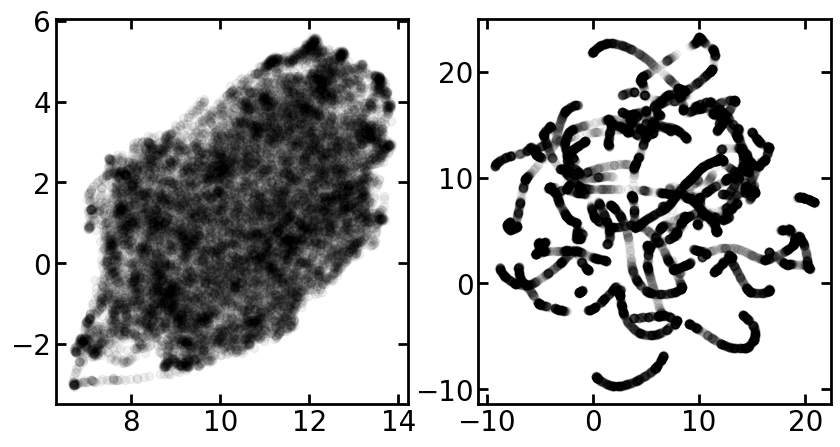

In [552]:
plt.subplot(1, 2, 1)
plt.scatter(signal_me_w[:, 0], signal_me_w[:, 1], c='k', alpha=0.05)
plt.subplot(1, 2, 2)
plt.scatter(signal_me_a[:, 0], signal_me_a[:, 1], c='k', alpha=0.05)
plt.show()

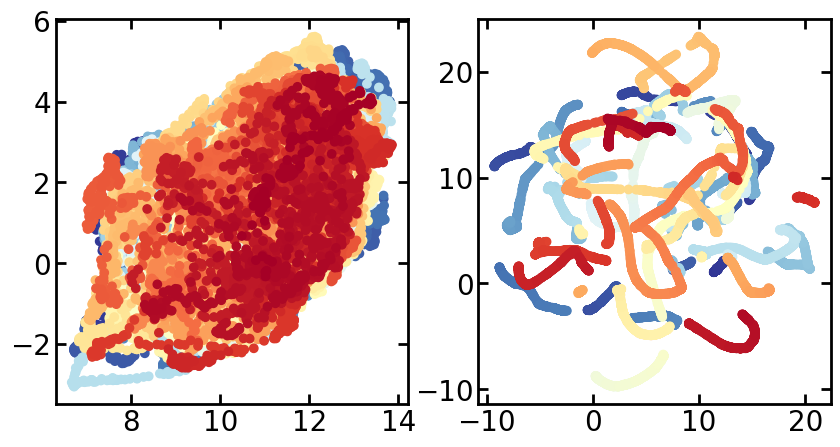

In [564]:
plt.subplot(1, 2, 1)
norm = Normalize(0, signal_me_w.shape[0])
colors = [cmap(norm(i)) for i in range(signal_me_w.shape[0])]
plt.scatter(signal_me_w[:, 0], signal_me_w[:, 1], color=colors)

plt.subplot(1, 2, 2)
plt.scatter(signal_me_a[:, 0], signal_me_a[:, 1], color=colors)
plt.show()

In [ ]:
# # pd.to_pickle(all_sigs, "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/all_embedded_sigs")
# all_sigs = pd.read_pickle("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/all_embedded_sigs")

In [530]:
plt.subplot(1, 2, 2)all_sigs[0]

(array([[-2.03410511, -1.60833007],
        [-2.16602003, -1.83114434],
        [-2.18366456, -1.85660994],
        ...,
        [-0.67551908, -0.16776202],
        [-0.6726724 , -0.17135805],
        [-0.68446103, -0.18448467]]),
 array([], shape=(0, 2), dtype=float64))

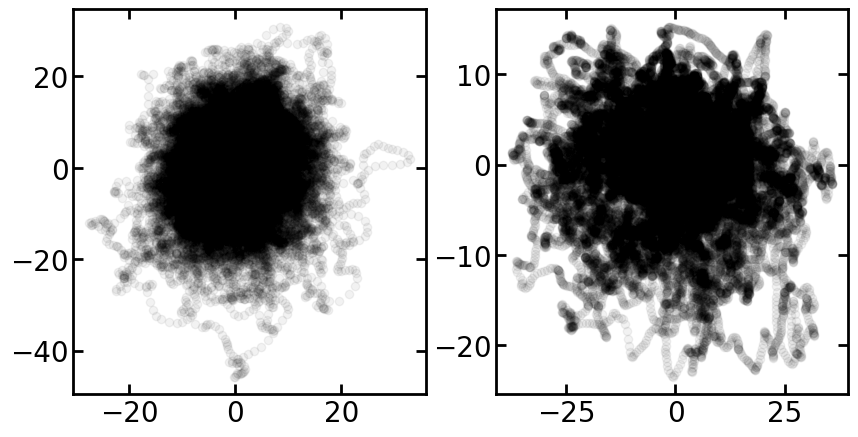

In [548]:
plt.subplot(1, 2, 1)
plt.scatter(all_sigs[0][0][:, 0], all_sigs[0][0][:, 1], c='k', alpha=0.05)
plt.subplot(1, 2, 2)
plt.scatter(all_sigs[0][1][:, 0], all_sigs[0][1][:, 1], c='k', alpha=0.05)

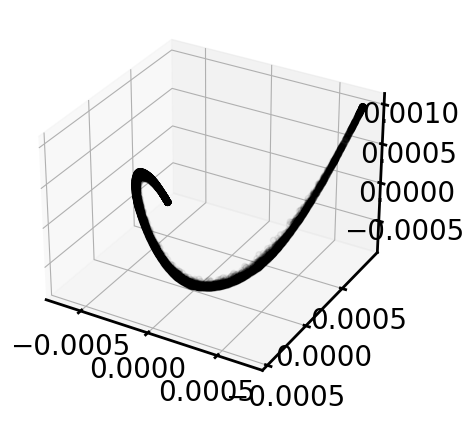

In [157]:
%matplotlib inline
i = 0
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
axs.scatter(all_sigs[i][:, 0], all_sigs[i][:, 1], all_sigs[i][:, 2], c='k', alpha=0.05)

# plt.scatter(aligned[:, 0], aligned[:, 1], c='k', alpha=0.05)

# i = 59
# plt.scatter(all_sigs[i][:, 0], all_sigs[i][:, 1], c='k', alpha=0.05)

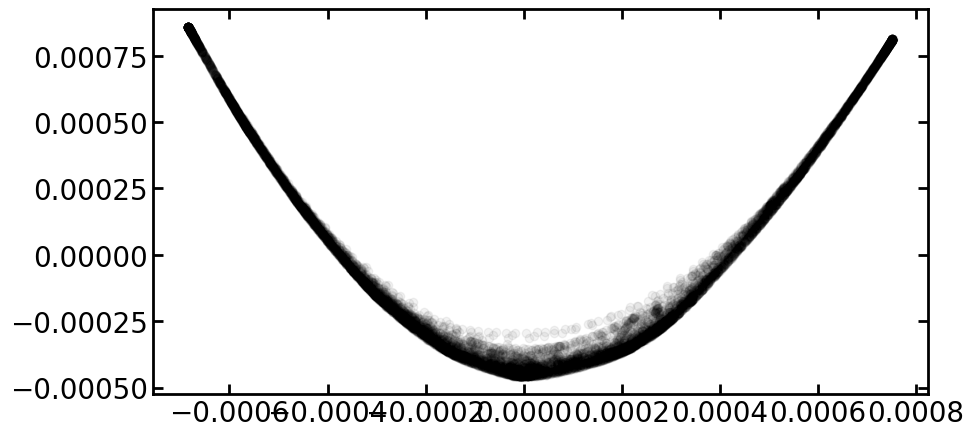

In [139]:
%matplotlib inline
i = 0
plt.scatter(all_sigs[i][:, 0], all_sigs[i][:, 1], c='k', alpha=0.05)

# plt.scatter(aligned[:, 0], aligned[:, 1], c='k', alpha=0.05)

# i = 59
# plt.scatter(all_sigs[i][:, 0], all_sigs[i][:, 1], c='k', alpha=0.05)

In [99]:
all_sigs[0].shape

(12000, 3)

In [106]:
norm = Normalize(0, all_sigs[0].shape[0])

  0%|          | 0/6000 [00:00<?, ?it/s]

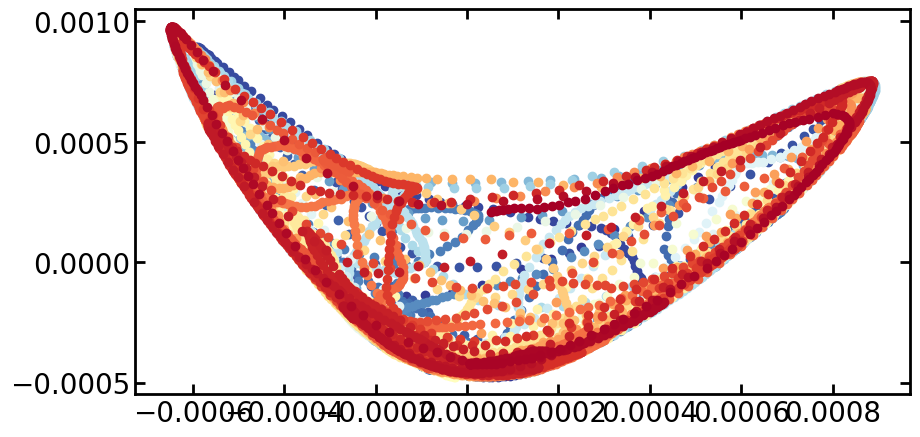

In [108]:
%matplotlib inline
for i in tqdm(range(0, all_sigs[0].shape[0], 2)):
    plt.scatter(all_sigs[0][i:i+2, 0], all_sigs[0][i:i+2, 1], color=cmap(norm(i)))

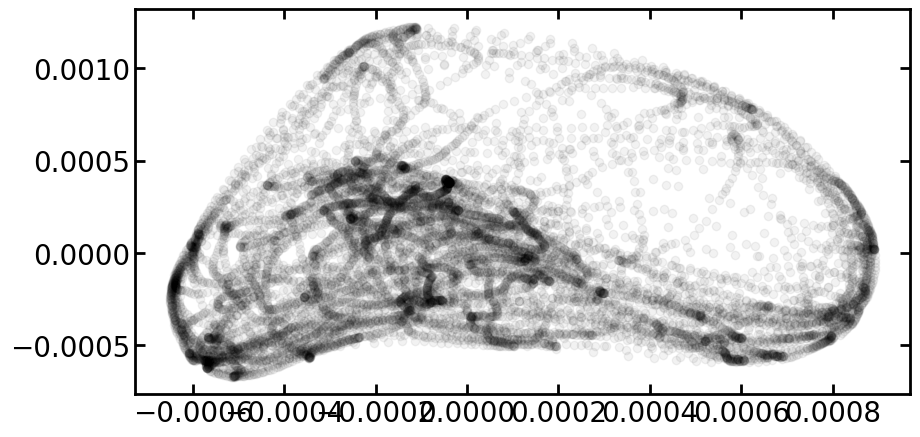

In [119]:
%matplotlib inline
plt.scatter(all_sigs[i][:, 0], all_sigs[i][:, 2], c='k', alpha=0.05)

<IPython.core.display.Javascript object>


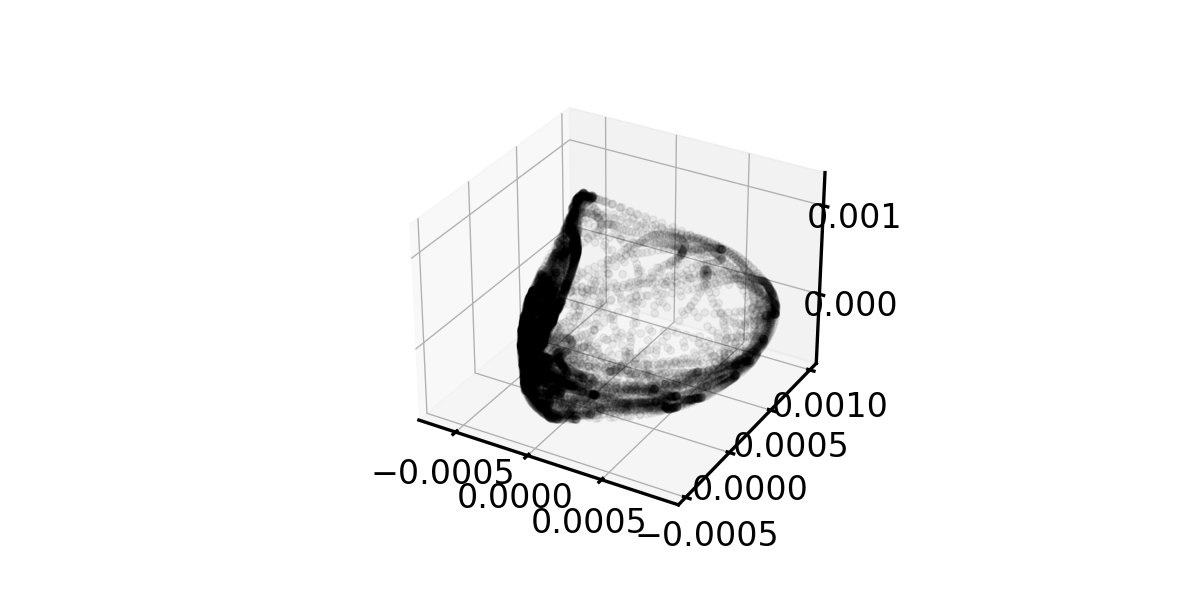

In [114]:
%matplotlib notebook
fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="3d"))

i = 0
axs.scatter(all_sigs[i][:, 0], all_sigs[i][:, 1], all_sigs[i][:, 2], c='k', alpha=0.05)

# axs.view_init(elev=15., azim=50)

# plt.scatter(aligned[:, 0], aligned[:, 1], c='k', alpha=0.05)

# i = 59
# axs.scatter(all_sigs[i][:, 0], all_sigs[i][:, 1], all_sigs[i][:, 2], c='k', alpha=0.01)

1.648515262083685

generating plot ...


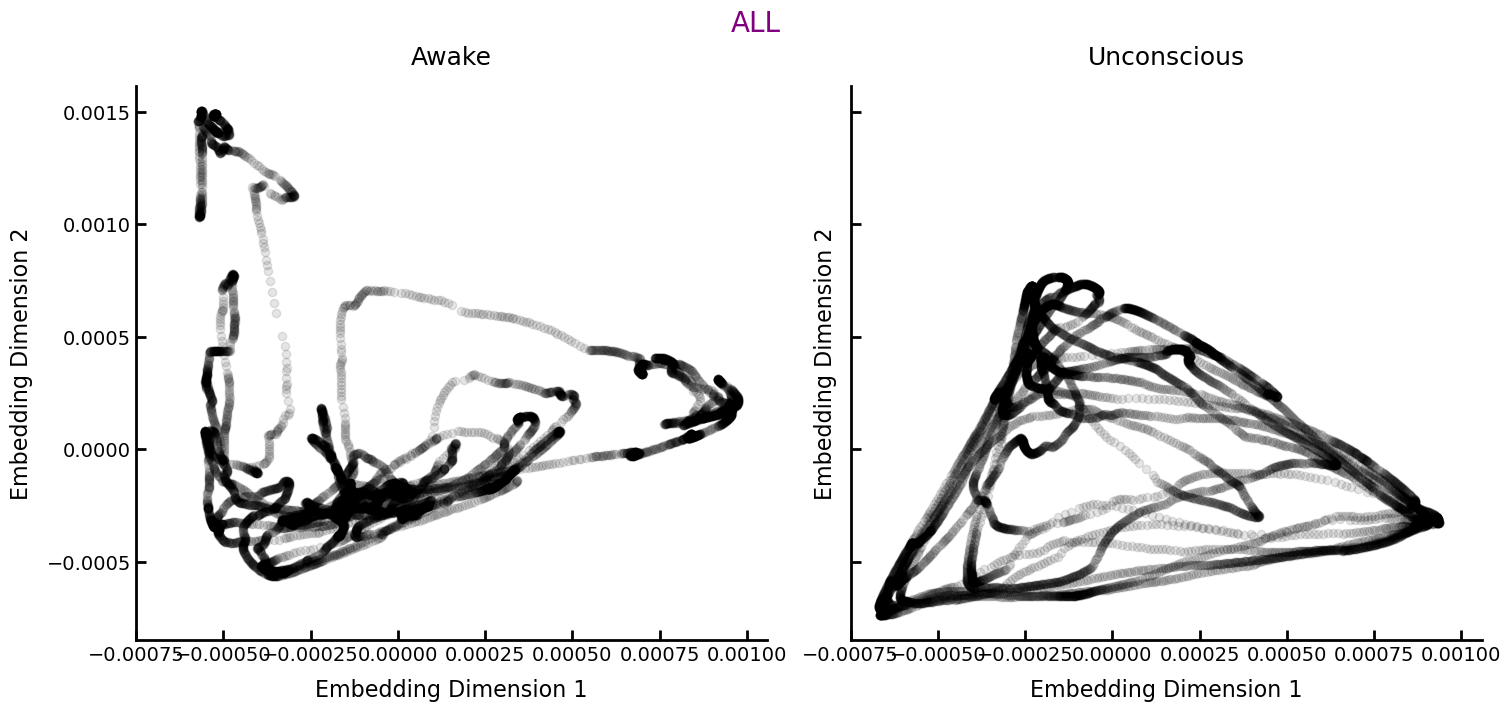

In [227]:
subtitle_fontsize = 18
subsuptitle_fontsize = 20
ylabel_fontsize = 16
xlabel_fontsize = 16
tick_fontsize = 14

fig = plt.figure(layout='constrained', figsize=(15, 7))
areas = ['all']
subfigs = fig.subfigures(1, 1, wspace=0.07, hspace=0.07)
for i, area in enumerate(areas):
    if len(areas) == 1:
        subfig = subfigs
    print("generating plot ...")
        
    if three_dim:
        axs = subfig.subplots(1, 2, subplot_kw=dict(projection="3d"))
    else:
        axs = subfig.subplots(1, 2, sharex=True, sharey=True)

    if scatter:
        plot_funcs = [axs[0].scatter, axs[1].scatter]
    else:
        plot_funcs = [axs[0].plot, axs[1].plot]


    if density_plot:
        c = 'k'
        alpha = 0.1
        if not three_dim:
            plot_funcs[0](signal_wake_me[start_ind:end_ind, 0], signal_wake_me[start_ind:end_ind, 1], color=c, alpha=alpha)
            plot_funcs[1](signal_anesthesia_me[start_ind:end_ind, 0], signal_anesthesia_me[start_ind:end_ind, 1], color=c, alpha=alpha)
        else:
            plot_funcs[0](signal_wake_me[start_ind:end_ind, 0], signal_wake_me[start_ind:end_ind, 1], signal_wake_me[start_ind:end_ind, 2], color=c, alpha=alpha)
            plot_funcs[1](signal_anesthesia_me[start_ind:end_ind, 0], signal_anesthesia_me[start_ind:end_ind, 1], signal_anesthesia_me[start_ind:end_ind, 2], color=c, alpha=alpha)
    else:
        for i in tqdm(range(start_ind, end_ind, 2)):
            c = cmap(norm(i))
            alpha=0.8
            if not three_dim:
                plot_funcs[0](signal_wake_me[i:i+2, 0], signal_wake_me[i:i+2, 1], color=c, alpha=alpha)
                plot_funcs[1](signal_anesthesia_me[i:i+2, 0], signal_anesthesia_me[i:i+2, 1], color=c, alpha=alpha)
            else:
                plot_funcs[0](signal_wake_me[i:i+2, 0], signal_wake_me[i:i+2, 1], signal_wake_me[i:i+2, 2], color=c, alpha=alpha)
                plot_funcs[1](signal_anesthesia_me[i:i+2, 0], signal_anesthesia_me[i:i+2, 1], signal_anesthesia_me[i:i+2, 2], color=c, alpha=alpha)
    axs[0].set_title(f'Awake', fontsize=subtitle_fontsize)
    axs[1].set_title(f'Unconscious', fontsize=subtitle_fontsize)
    subfig.suptitle(area_labels[area], color=area_colors[area], fontsize=subsuptitle_fontsize)
    
    for ax in axs:
        if embed_type == 'PCA':
            ax.set_xlabel('PC1', fontsize=xlabel_fontsize)
            ax.set_ylabel('PC2', fontsize=ylabel_fontsize)
        else:
            ax.set_xlabel('Embedding Dimension 1', fontsize=xlabel_fontsize)
            ax.set_ylabel('Embedding Dimension 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
    if not three_dim:
        for ax in axs:
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.tick_params(axis='y', which='both', left=True, right=False)
    else:
        for ax in axs:
            ax.grid(False)
            ax.set_ylabel('PC3', fontsize=ylabel_fontsize)
            
    def update_lim(lim, ax_lim):
        if ax_lim[0] < lim[0]:
            lim[0] = ax_lim[0]
        if ax_lim[1] > lim[1]:
            lim[1] = ax_lim[1]
        
        return lim
    
    if three_dim:
        pass
#         for ax in axs:
#             set_axes_equal(ax)
        
#         xlim, ylim, zlim = [np.Inf, -np.Inf], [np.Inf, -np.Inf], [np.Inf, -np.Inf]
#         for ax in axs:
#             xlim = update_lim(xlim, ax.get_xlim())
#             ylim = update_lim(ylim, ax.get_ylim())
#             zlim = update_lim(zlim, ax.get_zlim())
        
#         for ax in axs:
#             ax.set_xlim(xlim)
#             ax.set_ylim(ylim)
#             ax.set_zlim(zlim)

    # fig.suptitle(f"Isomap on {num_trajs} Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
    # fig.suptitle(f"Isomap on Continuous Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
    # fig.suptitle(f"{embed_type} on Wake Start = {start_wake:.3f} s, Anesthesia Start = {start_anesthesia:.3f} s\n{'Not ' if not standardize else ''}Standardized, Length = {(window_lfp*dt if mode == 'lfp' else (window_rate*dt_rate)):.2f} s ({window_lfp if mode == 'lfp' else window_rate} steps), {'Shared' if shared_basis else 'Split'} Basis, indices {start_ind} - {end_ind}, Lowpass Filter = {lowpass_filter}")

    
if not density_plot:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#         fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([1.05, 0.15, 0.01, 0.7])
    # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
    # cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(start_ind, end_ind + 1, cbar_step), label='Time Relative to Tone (ms)')
    cbar.ax.set_yticklabels(np.arange(start_ind, end_ind + 1, cbar_step), fontsize=12)
    cbar.set_label(label=f'Time Relative to Trajectory Start (s)', fontsize=14)

    
plt.show()

In [31]:
# subtitle_fontsize = 18
# subsuptitle_fontsize = 20
# ylabel_fontsize = 16
# xlabel_fontsize = 16
# tick_fontsize = 14

# fig = plt.figure(layout='constrained', figsize=(15, 7))
# subfigs = fig.subfigures(2, 2, wspace=0.07, hspace=0.07)

# for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
#     subfig = subfigs[int(i/2)][i % 2]
#     print("-"*40)
#     print(f"AREA = {area}")
#     print("-"*40)
#     print("loading data...")
#     if area == 'all':
#         unit_indices = np.arange(len(unit_info['area']))
#     else:
#         unit_indices = np.where(electrode_info['area'] == area)[0]
        
#     signal_wake = load_window_from_chunks(start_wake, start_wake + window, directory, unit_indices)
#     signal_anesthesia = load_window_from_chunks(start_anesthesia, start_anesthesia + window, directory, unit_indices)
    
#     if lowpass is not None:
#         for i in range(signal_wake.shape[1]):
#             signal_wake[:, i] = butter_lowpass_filter(signal_wake[:, i], lowpass, 1/dt, order=4)
#             signal_anesthesia[:, i] = butter_lowpass_filter(signal_anesthesia[:, i], lowpass, 1/dt, order=4)
    
#     if gaussian is not None:
#         for i in range(signal_wake.shape[1]):
#             signal_wake[:, i] = scipy.ndimage.gaussian_filter1d(signal_wake[:, i], gaussian)
#             signal_anesthesia[:, i] = scipy.ndimage.gaussian_filter1d(signal_anesthesia[:, i], gaussian)

#     if delay_embed:
#         signal_wake = DeLASE(signal_wake, matrix_size=1000, use_torch=False, svd=False).H
#         signal_anesthesia = DeLASE(signal_anesthesia, matrix_size=1000, use_torch=False, svd=False).H

#     if embed_type == 'PCA':
#         manifold_embed = lambda n_comp: PCA(n_components=n_comp, use_torch=True, device='cuda')
#     else: # embed_type = 'Isomap'
#         n_neighbors = 5
#         manifold_embed = lambda n_comp: Isomap(n_components=n_comp, n_neighbors=n_neighbors)
#         lfp_duration_s = 1 # s

#     if standardize:
#         signal_wake = (signal_wake - signal_wake.mean())/signal_wake.std()
#         signal_anesthesia = (signal_anesthesia - signal_anesthesia.mean())/signal_anesthesia.std()
    
#     print("performing PCA...")
#     n_components = 3
#     if shared_basis:
#         me_w = manifold_embed(n_components)
#         me_w.fit(np.vstack([signal_wake, signal_anesthesia]))
#         signal_wake_me = me_w.transform(signal_wake).cpu()
#         signal_anesthesia_me = me_w.transform(signal_anesthesia).cpu()
#         me_a = me_w
#     else:

#         me_w = manifold_embed(n_components)
#         signal_wake_me = me_w.fit_transform(signal_wake).cpu()

#         me_a = manifold_embed(n_components)
#         signal_anesthesia_me = me_a.fit_transform(signal_anesthesia).cpu()
        
#     print("generating plot ...")
        
#     if three_dim:
#         axs = subfig.subplots(1, 2, subplot_kw=dict(projection="3d"))
#     else:
#         axs = subfig.subplots(1, 2, sharex=True, sharey=True)

#     if scatter:
#         plot_funcs = [axs[0].scatter, axs[1].scatter]
#     else:
#         plot_funcs = [axs[0].plot, axs[1].plot]


#     if density_plot:
#         c = 'k'
#         alpha = 0.1
#         if not three_dim:
#             plot_funcs[0](signal_wake_me[start_ind:end_ind, 0], signal_wake_me[start_ind:end_ind, 1], color=c, alpha=alpha)
#             plot_funcs[1](signal_anesthesia_me[start_ind:end_ind, 0], signal_anesthesia_me[start_ind:end_ind, 1], color=c, alpha=alpha)
#         else:
#             plot_funcs[0](signal_wake_me[start_ind:end_ind, 0], signal_wake_me[start_ind:end_ind, 1], signal_wake_me[start_ind:end_ind, 2], color=c, alpha=alpha)
#             plot_funcs[1](signal_anesthesia_me[start_ind:end_ind, 0], signal_anesthesia_me[start_ind:end_ind, 1], signal_anesthesia_me[start_ind:end_ind, 2], color=c, alpha=alpha)
#     else:
#         for i in tqdm(range(start_ind, end_ind, 2)):
#             c = cmap(norm(i))
#             alpha=0.8
#             if not three_dim:
#                 plot_funcs[0](signal_wake_me[i:i+2, 0], signal_wake_me[i:i+2, 1], color=c, alpha=alpha)
#                 plot_funcs[1](signal_anesthesia_me[i:i+2, 0], signal_anesthesia_me[i:i+2, 1], color=c, alpha=alpha)
#             else:
#                 plot_funcs[0](signal_wake_me[i:i+2, 0], signal_wake_me[i:i+2, 1], signal_wake_me[i:i+2, 2], color=c, alpha=alpha)
#                 plot_funcs[1](signal_anesthesia_me[i:i+2, 0], signal_anesthesia_me[i:i+2, 1], signal_anesthesia_me[i:i+2, 2], color=c, alpha=alpha)
#     axs[0].set_title(f'Awake', fontsize=subtitle_fontsize)
#     axs[1].set_title(f'Unconscious', fontsize=subtitle_fontsize)
#     subfig.suptitle(area_labels[area], color=area_colors[area], fontsize=subsuptitle_fontsize)
    
#     for ax in axs:
#         ax.set_xlabel('PC1', fontsize=xlabel_fontsize)
#         ax.set_ylabel('PC2', fontsize=ylabel_fontsize)
#         ax.tick_params(labelsize=tick_fontsize)
    
#     if not three_dim:
#         for ax in axs:
#             ax.spines[['right', 'top']].set_visible(False)
#             ax.xaxis.set_ticks_position('bottom')
#             ax.tick_params(axis='y', which='both', left=True, right=False)
#     else:
#         for ax in axs:
#             ax.grid(False)
#             ax.set_ylabel('PC3', fontsize=ylabel_fontsize)
            
#     def update_lim(lim, ax_lim):
#         if ax_lim[0] < lim[0]:
#             lim[0] = ax_lim[0]
#         if ax_lim[1] > lim[1]:
#             lim[1] = ax_lim[1]
        
#         return lim
    
#     if three_dim:
#         for ax in axs:
#             set_axes_equal(ax)
        
#         xlim, ylim, zlim = [np.Inf, -np.Inf], [np.Inf, -np.Inf], [np.Inf, -np.Inf]
#         for ax in axs:
#             xlim = update_lim(xlim, ax.get_xlim())
#             ylim = update_lim(ylim, ax.get_ylim())
#             zlim = update_lim(zlim, ax.get_zlim())
        
#         for ax in axs:
#             ax.set_xlim(xlim)
#             ax.set_ylim(ylim)
#             ax.set_zlim(zlim)

#     # fig.suptitle(f"Isomap on {num_trajs} Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
#     # fig.suptitle(f"Isomap on Continuous Trajector{'ies' if num_trajs > 1 else 'y'} from {area} with {n_neighbors} Neighbors and Delay Lag p={p}, PCA dim = {n_pca_components}, Subsample = {subsample}", fontsize=19)
#     # fig.suptitle(f"{embed_type} on Wake Start = {start_wake:.3f} s, Anesthesia Start = {start_anesthesia:.3f} s\n{'Not ' if not standardize else ''}Standardized, Length = {(window_lfp*dt if mode == 'lfp' else (window_rate*dt_rate)):.2f} s ({window_lfp if mode == 'lfp' else window_rate} steps), {'Shared' if shared_basis else 'Split'} Basis, indices {start_ind} - {end_ind}, Lowpass Filter = {lowpass_filter}")

    
# if not density_plot:
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# #         fig.subplots_adjust(right=0.85)
#     cbar_ax = fig.add_axes([1.05, 0.15, 0.01, 0.7])
#     # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
#     # cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)

#     cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(start_ind, end_ind + 1, cbar_step), label='Time Relative to Tone (ms)')
#     cbar.ax.set_yticklabels(np.arange(start_ind, end_ind + 1, cbar_step)*dt_rate, fontsize=12)
#     cbar.set_label(label=f'Time Relative to Trajectory Start (s)', fontsize=14)

    
# plt.show()

In [154]:
signal_wake_me.shape

torch.Size([15000, 2])